In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline
random_seed = 42
random.seed(random_seed)

In [2]:
# Simulate data fetched from the database
# data = {
#     'ID': [101, 102, 103, 104, 105, 106, 107, 108],
#     'Feature_1': [1.0, 1.2, 5.0, 5.1, 1.1, 5.5, 1.5, 5.3],
#     'Feature_2': [2.0, 2.1, 6.0, 6.2, 2.3, 6.1, 2.2, 6.3]
# }
data = {
    'ID': [id for id in range(0, 100)],
    'Feature_1': [random.uniform(1.0, 100.0) for _ in range(0, 100)],
    'Feature_2': [random.uniform(2.0, 700.0) for _ in range(0, 100)]
}
df = pd.DataFrame(data)

# Separate the unique identifier (ID) from the features
# We will use only the features for clustering
features = df[['Feature_1', 'Feature_2']]

print("--- Original DataFrame (First 5 rows) ---")
print(df.head())

--- Original DataFrame (First 5 rows) ---
   ID  Feature_1   Feature_2
0   0  64.303253   10.013753
1   1   3.476065  505.063830
2   2  28.227903  477.833838
3   3  23.097863  376.805291
4   4  73.910650  188.243983


In [3]:
# Initialize and fit the K-Means model (let's assume k=2 for simple clusters)
kmeans = KMeans(n_clusters=3, random_state=random_seed, n_init=10)
kmeans.fit(features)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels as a new column to the original DataFrame
df['Cluster_ID'] = cluster_labels
print(df.head())

   ID  Feature_1   Feature_2  Cluster_ID
0   0  64.303253   10.013753           1
1   1   3.476065  505.063830           0
2   2  28.227903  477.833838           2
3   3  23.097863  376.805291           2
4   4  73.910650  188.243983           1


In [4]:
# Compute SSE (inertia) for a range of k values using KMeans
import numpy as np

# Define range of k to evaluate
k_range = range(1, 11)  # evaluate k = 1..10

sse = []  # sum of squared errors (inertia)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=random_seed, n_init=10)
    km.fit(features)
    sse.append(km.inertia_)

sse  # display the values in notebook

[4229079.08356436,
 1124171.624708775,
 465275.81365735503,
 321976.12254767807,
 203347.0279049714,
 166495.63137630542,
 143656.29869787116,
 121437.11866872056,
 106460.16949193619,
 92219.6961354346]

C:\Users\ler_s\AppData\Local\Temp\ipykernel_21876\733973898.py:25: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dists = np.abs(np.cross(line_vec, start - pts)) / line_len


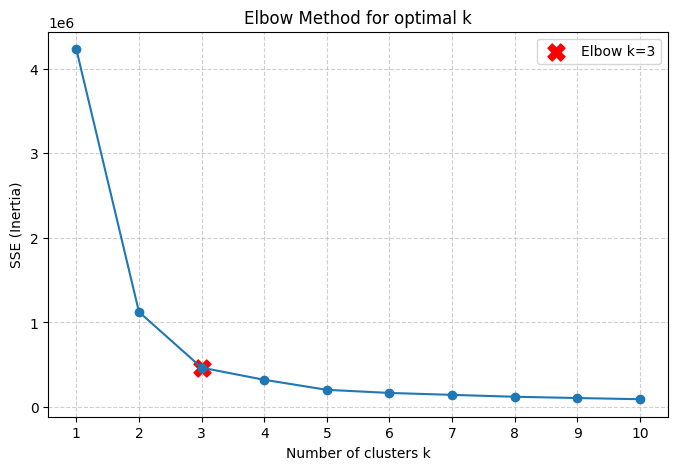

Suggested k (elbow): 3


In [5]:
# Plot the elbow graph and detect the elbow using max-distance to line method
import numpy as np
import matplotlib.pyplot as plt

k_vals = np.array(list(k_range))
sse_vals = np.array(sse)

plt.figure(figsize=(8,5))
plt.plot(k_vals, sse_vals, '-o', color='tab:blue')
plt.xticks(k_vals)
plt.xlabel('Number of clusters k')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for optimal k')
plt.grid(True, linestyle='--', alpha=0.6)

# Elbow detection: distance from each point to line connecting first and last
pts = np.column_stack((k_vals, sse_vals))
start = pts[0]
end = pts[-1]
line_vec = end - start
line_len = np.linalg.norm(line_vec)
if line_len == 0:
    elbow_k = k_vals[0]
else:
    dists = np.abs(np.cross(line_vec, start - pts)) / line_len
    elbow_idx = np.argmax(dists)
    elbow_k = int(k_vals[elbow_idx])

# Highlight suggested elbow
plt.scatter(elbow_k, sse_vals[elbow_idx], s=150, c='red', marker='X', label=f'Elbow k={elbow_k}')
plt.legend()
plt.show()

print(f"Suggested k (elbow): {elbow_k}")

In [6]:
print("\n--- DataFrame with Cluster Assignments ---")
print(df)

# To get the final data ready for a database update:
cluster_results = df[['ID', 'Cluster_ID']]

print("\n--- Final Results to Store/Update in Database ---")
print(cluster_results)


--- DataFrame with Cluster Assignments ---
    ID  Feature_1   Feature_2  Cluster_ID
0    0  64.303253   10.013753           1
1    1   3.476065  505.063830           0
2    2  28.227903  477.833838           2
3    3  23.097863  376.805291           2
4    4  73.910650  188.243983           1
..  ..        ...         ...         ...
95  95  38.780309  603.221675           0
96  96  99.616017  386.127068           2
97  97  53.382320   37.310654           1
98  98  97.136759  699.499163           0
99  99  86.217191  585.547254           0

[100 rows x 4 columns]

--- Final Results to Store/Update in Database ---
    ID  Cluster_ID
0    0           1
1    1           0
2    2           2
3    3           2
4    4           1
..  ..         ...
95  95           0
96  96           2
97  97           1
98  98           0
99  99           0

[100 rows x 2 columns]


d:\workspace\machine-learning\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


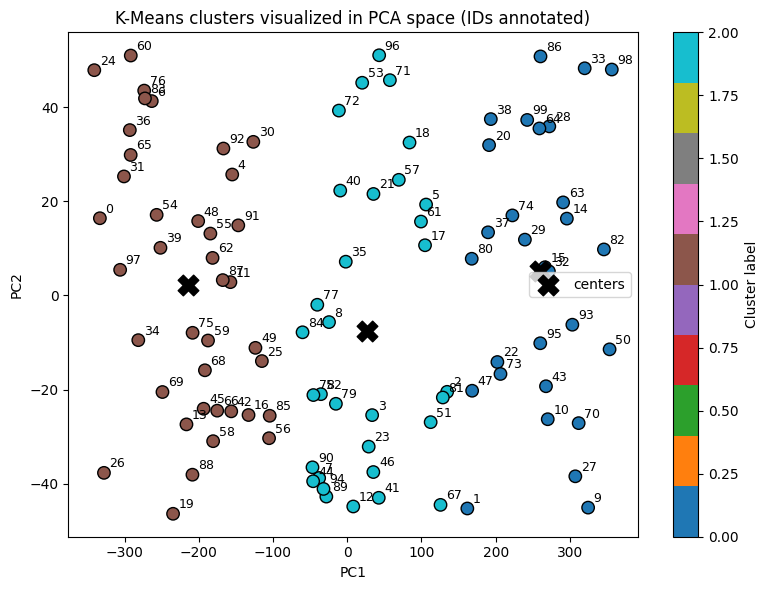

In [7]:
# Perform PCA to reduce features to 2D and plot clusters with ID annotations
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

# If 'features' and 'kmeans' are defined by running earlier cells, reuse them.
# Otherwise, re-run the clustering cell above.

pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features)

# Project cluster centers to PCA space (requires kmeans fitted earlier)
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)

plt.figure(figsize=(8,6))
scatter = plt.scatter(features_pca[:,0], features_pca[:,1], c=cluster_labels, cmap='tab10', s=80, edgecolor='k')
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', s=220, marker='X', label='centers')

# Annotate each point with its ID from the DataFrame
for i, id_val in enumerate(df['ID'].values):
    plt.annotate(str(id_val), (features_pca[i,0], features_pca[i,1]),
                 xytext=(4,4), textcoords='offset points', fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means clusters visualized in PCA space (IDs annotated)')
plt.legend(loc='best')
plt.colorbar(scatter, label='Cluster label')
plt.tight_layout()
plt.show()